# Modell Predictive Control

In [1]:
from optimierung import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import osqp

In [2]:
# Model parameters
g = 9.81
m = 1
l = 0.3
J = 0.2*m*l**2

h = 0.05   # Time step 20 Hz

In [3]:
# Modell
def quad_dynamics(x,u):
    '''
    x:         [x, y, theta, xd, yd, thetad]
    '''
    xd = np.zeros(len(x))

    theta = x[2]

    xd[3] = (u[0] + u[1])*np.sin(theta)/m     #xdd
    xd[4] = (u[0] + u[1])*np.cos(theta)/m -g  # ydd    
    xd[5] = (u[1] - u[0])*l/(J*2)            # thetadd
    
    xd[0],xd[1], xd[2] = x[3],x[4],x[5] 
    return xd

In [4]:
def runge_kutta_k4(f,x,u):
    #RK4 integration with zero-order hold on u
    h = 0.05      # time step (20Hz) 

    f1 = f(x, u)
    f2 = f(x + 1/2*h*f1, u)
    f3 = f(x + 1/2*h*f2, u)
    f4 = f(x + h*f3, u)

    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)

In [5]:
x_hover = np.zeros((6))
u_hover = [0.5*m*g, 0.5*m*g]
A = np.array([[0,0,0,  1,0,0],
              [0,0,0,  0,1,0],
              [0,0,0,  0,0,1],
              [0,0,-g, 0,0,0],
              [0,0,0,  0,0,0],
              [0,0,0,  0,0,0]])
B = np.array([[0,0],
              [0,0],
              [0,0],
              [0,0],
              [1/m, 1/m],
              [-l/(2*J), -l/(2*J)]])
runge_kutta_k4(quad_dynamics, x_hover,u_hover)

array([0., 0., 0., 0., 0., 0.])

In [6]:
Nx = 6
Nu = 2
Tfinal = 10
Nt = round(Tfinal/h)+1

thist = np.linspace(0,Tfinal,Nt)


###  MPC Cost Function
$
T = \sum^{H}_{n=1} [\frac{1}{2}(x_{n}-x_{ref})^{T}Q(x_{n}-x_{ref}) + \frac{1}{2}(u_{n}-u_{ref})^{T}R(u_{n}-u_{ref}) + (x_{H}-x_{ref})^{T}P(x_{H}-x_{ref})] 
$

In [7]:
# Cost weights
Q = np.eye(Nx)
R = np.eye(Nu)*0.01
Qn = np.eye(Nx)

In [8]:
# Kostenfunktion
def cost(xhist, uhist):
    cost = 0
    cost = xhist[:,-1]@Qn@xhist[:,-1]                                     # Kosten für den Endzustand
    for k in range(np.size(xhist,1)):
        cost +=  ( xhist[:,k]@Q@xhist[:,k] + uhist[k]@R@uhist[k] )/2
    return cost

In [9]:
# LQR Controller
import control as ct

P_,L,K = ct.dare(A,B,Q,R)
K,S,E = ct.dlqr(A,B,Q,R)


lqr_controller= lambda x,xref: u_hover-K@(np.subtract(x,xref))

## Build Quadratic Problem
**https://github.com/qpsolvers/qpsolvers**      
https://osqp.org/docs/examples/mpc.html       
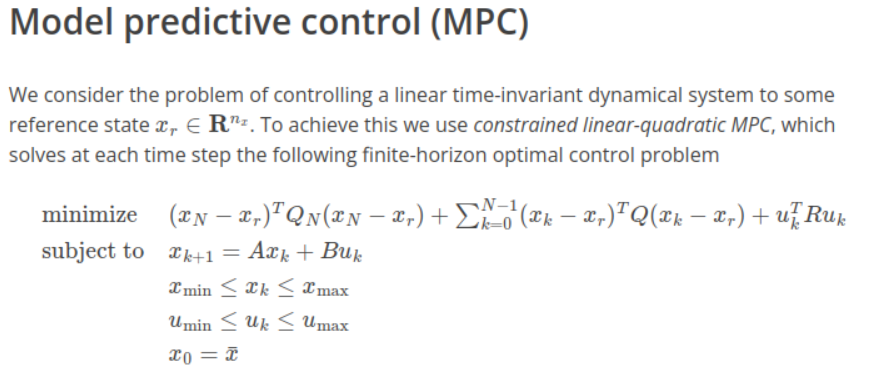

In [10]:
import osqp
from scipy import sparse
import scipy.signal as sig


Ta = 0.05
C = np.zeros((6,0))
C[2] = 0
D = np.zeros((2,0))
# Constraints
Ad_,Bd_,Cd,Dd,Ta = sig.cont2discrete((A,B,C,D),Ta)
Ad = sparse.csr_matrix(A)
Bd = sparse.csr_matrix(B)
[nx, nu] = Bd.shape


# Thrust limits
umin = [0.2*m*g, 0.2*m*g]   #[-np.inf, -np.inf] #
umax = [0.6*m*g, 0.6*m*g] # [np.inf, np.inf]  #[0.6*m*g, 0.6*m*g]

xmin = np.array([np.inf, np.inf, np.inf, np.inf,np.inf, np.inf])*(-1)   # No x-limitation
xmax = np.array([ np.inf, np.inf, np.inf, np.inf,np.inf, np.inf])

# Objective function
Q = np.eye(nx)
R = np.eye(nu)*0.01
QN = np.eye(nx)*1

# Initial and reference states
x0 = np.zeros(nx)
xr = [5,2,0, 0,0,0] #np.zeros(nx)

# Prediction horizon
N = 20


# Cast MPC problem to a QP: x = (x(0),x(1),...,x(N),u(0),...,u(N-1))
# - quadratic objective
P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,sparse.kron(sparse.eye(N), R)], format='csc')
# - linear objective
q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),np.zeros(N*nu)])
# - linear dynamics
Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N+1, k=-1), Ad)
Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, N)), sparse.eye(N)]), Bd)
Aeq = sparse.hstack([Ax, Bu])
leq = np.hstack([-x0, np.zeros(N*nx)])
ueq = leq
# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)
lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), np.subtract(umin,u_hover))])
uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), np.subtract(umax,u_hover))])
# - OSQP constraints
Ab = sparse.vstack([Aeq, Aineq], format='csc')
lb = np.hstack([leq, lineq])
ub = np.hstack([ueq, uineq])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P, q, Ab, lb, ub,  verbose=False)#, eps_abs=1e-8, eps_rel=1e-8, polish=1)   
res = prob.solve()
#print(res.x)
#print(res.x[-N*nu:-(N-1)*nu])


In [11]:
# MPC Controller

def mpc_controller(x,xref):
    # Update OP problem
    for i in range(0,nx):
        lb[i] = -x[i]
        ub[i] = -x[i]

    # Update b_Vector --> Referenzvektor 
    b = np.hstack([np.kron(np.ones(N), -Q@xref), -P_@xref,np.zeros(N*nu)])     
    
    prob.update(q=b, l=lb, u=ub)

    #Solve QP
    res = prob.solve()
    # Check solver status
    if res.info.status != 'solved':
        raise ValueError('OSQP did not solve the problem!')
    ctrl = res.x[-N*nu:-(N-1)*nu]
    
    return ctrl+u_hover

    

In [12]:
def close_loop(x0,controller,x_ref,N):
    xhist = np.zeros((nx,N))
    u0 = controller(x0,x_ref)
    uhist = np.zeros((nu,N-1))
    uhist[:,0] = u0
    xhist[:,0] = x0
    for k in range(0,N-1):
        uhist[:,k] = controller(xhist[:,k],x_ref)
        # Input satturation        
        for i in range(0,nu):            
            if uhist[i,k]>umax[i]:                
                uhist[i,k] = umax[i]
            elif uhist[i,k]<umin[i]:
                uhist[i,k] = umin[i]                                    
        
        xhist[:,k+1] = A@xhist[:,k]+B@uhist[:,k]   # runge_kutta_k4(quad_dynamics, xhist[:,k], uhist[:,k])  
    return xhist,uhist  

In [13]:
x_ref = [5,2,0, 0,0,0]
x0 = np.array([1,2,0, 0,0,0])
xhist1,uhist1 = close_loop(x0,mpc_controller,x_ref,Nt)
xhist2,uhist2 = close_loop(x0,lqr_controller,x_ref,Nt)

#lq_controller= lambda x,xref: [0.0*m*g, 0.0*m*g]
#xhist2,uhist2 = close_loop(x0,lq_controller,x_ref,Nt)

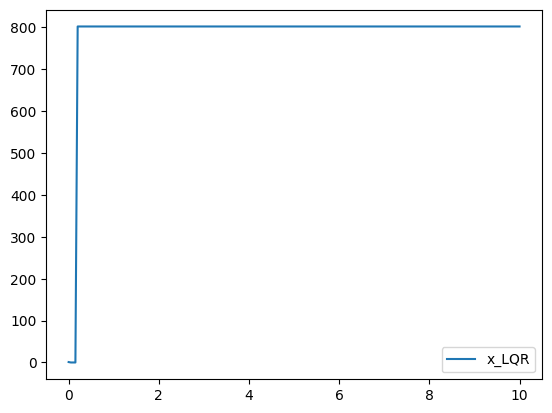

In [14]:
#plt.plot(thist,xhist1[0,:], label = 'x-MPC')
plt.plot(thist,xhist2[0,:], label = 'x_LQR')
plt.legend()

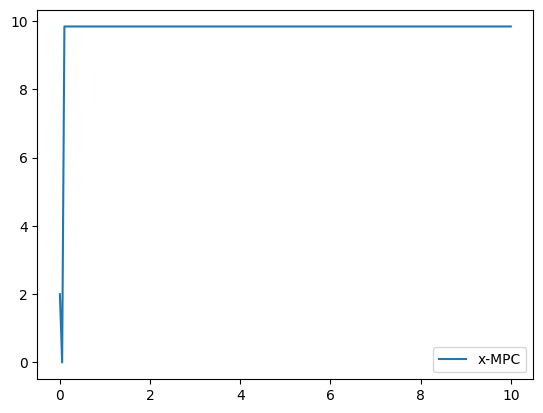

In [15]:
plt.plot(thist,xhist1[1,:], label = 'x-MPC')
#plt.plot(thist,xhist2[1,:], label = 'x_LQR')
plt.legend()

[5.886, 5.886]
[1.9620000000000002, 1.9620000000000002]


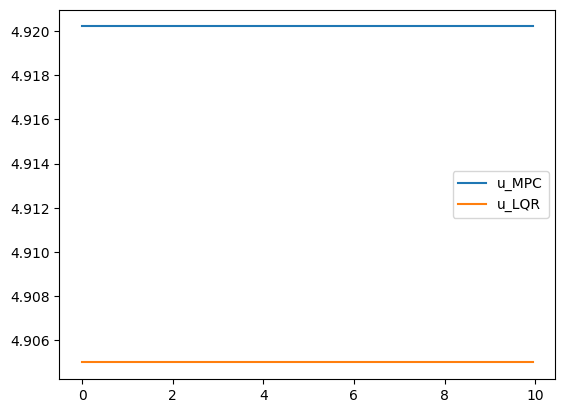

In [16]:
plt.plot(thist[0:Nt-1],uhist1[0,:],label='u_MPC')
plt.plot(thist[0:Nt-1],uhist2[0,:], label = 'u_LQR')
plt.legend()
print(umax)
print(umin)